In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 


from sklearn.preprocessing import MinMaxScaler
from umap import UMAP
from sklearn.cluster import DBSCAN

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = set(ENGLISH_STOP_WORDS)
stop_words.add('said')
ENGLISH_STOP_WORDS = frozenset(stop_words)

from collections import defaultdict
import re
import pickle

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 100)

import plotly.graph_objects as go
import plotly.io as pio
from typing import List, Union

In [3]:
import requests
import csv
from itertools import permutations


from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

### Importing summed topics over time for Nature publications from 2005 to 2022 (see BERTopic notebook):

In [5]:
df_0 = pd.read_csv('data/nature_2005_2022_summed_topics_over_time.csv')

In [6]:
df_1 = pd.read_csv('data/nature_2005_2022_summed_topics_over_time_month.csv')

In [7]:
df_0

,Topic,Timestamp,Words,Frequency
0,0,2005,"infectiousness, dynavax, meters, belated, plotkin",4
1,0,2006,"vaccine, lyme, dextrose, toil, distrusted",7
2,0,2007,"sthr, klaus, novartis, vaccine, vaccines",7
3,0,2008,"vaccine, standardizes, selfdefence, oncequiet, 1966",8
4,0,2009,"jabs, vaccine, pandemics, flu, creditors",9
...,...,...,...,...
4620,308,2017,"inequality, activity, smartphone, obesity, physical",1
4621,308,2018,"obesity, slims, heretical, cruel, galileos",2
4622,308,2019,"rural, bmi, obesity, bodymass, middleincome",2
4623,308,2021,"obesitys, born, racially, skewed, 1950s",1


In [8]:
df_1

,Topic,Timestamp,Words,Frequency,Name
0,0,2005-09-01,"dynavax, plotkin, vaccinology, directors, epidemiologist",1,0_covid_coronavirus_covid19_vaccine
1,0,2005-10-01,"belated, acknowledgement, bushs, rhetoric, welcome",1,0_covid_coronavirus_covid19_vaccine
2,0,2005-11-01,"meters, infectiousness, sneeze, infectious, superspreading",2,0_covid_coronavirus_covid19_vaccine
3,0,2006-01-01,"opposition, faith, lose, children, public",1,0_covid_coronavirus_covid19_vaccine
4,0,2006-02-01,"lyme, vaccine, dextrose, distrusted, skiers",3,0_covid_coronavirus_covid19_vaccine
...,...,...,...,...,...
17739,308,2018-01-01,"slims, procedure, surgery, persist, cuts",1,308_obesity_rural_bmi_bodymass
17740,308,2018-09-01,"obesity, heretical, cruel, galileos, longlost",1,308_obesity_rural_bmi_bodymass
17741,308,2019-05-01,"rural, bmi, obesity, bodymass, middleincome",2,308_obesity_rural_bmi_bodymass
17742,308,2021-04-01,"obesitys, born, racially, skewed, 1950s",1,308_obesity_rural_bmi_bodymass


In [9]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17744 entries, 0 to 17743
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Topic      17744 non-null  int64 
 1   Timestamp  17744 non-null  object
 2   Words      17744 non-null  object
 3   Frequency  17744 non-null  int64 
 4   Name       17744 non-null  object
dtypes: int64(2), object(3)
memory usage: 693.3+ KB


In [10]:
df_1['Timestamp'] = pd.to_datetime(df_1['Timestamp']) 

In [11]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17744 entries, 0 to 17743
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Topic      17744 non-null  int64         
 1   Timestamp  17744 non-null  datetime64[ns]
 2   Words      17744 non-null  object        
 3   Frequency  17744 non-null  int64         
 4   Name       17744 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 693.3+ KB


Removing entries from 2023, since not complete for the year:

In [12]:
df_0 = df_0[df_0['Timestamp'] != 2023]

In [13]:

df_1 = df_1[df_1['Timestamp'].dt.year != 2023]

Trying to make a suitable custom dataframe with the time, topic and frequency information,
the idea was to do a groupby of 'Timestamp' and 'Topic', followed by a value count of 'Frequency':

In [14]:
df_0_grouped_by_topic_year = df_0.groupby(['Timestamp', 'Topic'])

In [15]:
df_0_grouped = df_0_grouped_by_topic_year['Frequency'].value_counts().unstack()

In [17]:
df_0_grouped

Frequency        1    2    3    4    5    6    7    8    9    10   ...  65   \
Timestamp Topic                                                    ...        
2005      0      NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  ...  NaN   
          4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2022      303    NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          304    NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          305    NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          307    NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          308    1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   

Frequency        66   83   88   90   104  114  220  472  474  
Timestamp Topic                                               
2005      0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  
2022      303    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          304    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          305    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          307    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          308    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[4593 rows x 70 columns]

Almost there, but I could not figure out how to change Frequency into a column, .melt() did not work with Timestamp as the index and 
an index reset changes the logic of the dataframe

Different approach, groupby of 'Topic' and 'Timestamp' and .sum() of 'Frequency',
followed by pivoting the dataframe with .pivot() and making 'Timestamp' the index, 'Topic' the columns and 
'Frequency' the values, so all three informations are in a dataframe for plotting and time series forecasting:

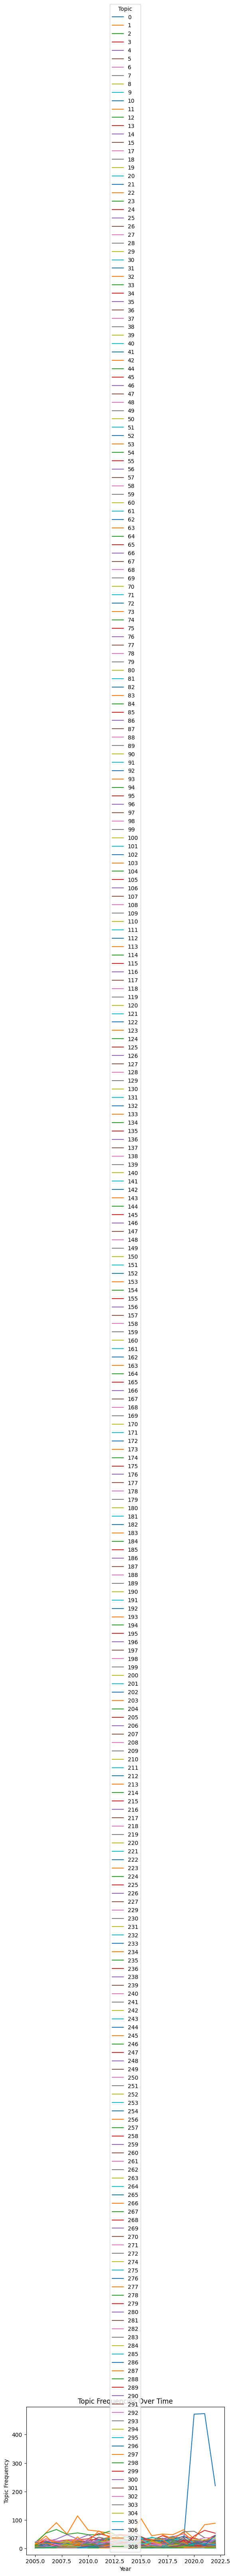

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by "Topic" and "Timestamp" and aggregate "Frequency"
grouped_df = df_0.groupby(['Topic', 'Timestamp'])['Frequency'].sum().reset_index()

# Pivot the DataFrame to get years on the x-axis and Topic Frequencies as columns
pivot_df = grouped_df.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Plot the data with a legend
pivot_df.plot(kind='line', legend=True)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Topic Frequency')
plt.title('Topic Frequencies Over Time')

# Show the plot
plt.show()

# The pivot_df DataFrame can be used for time series analysis


With monthly data:

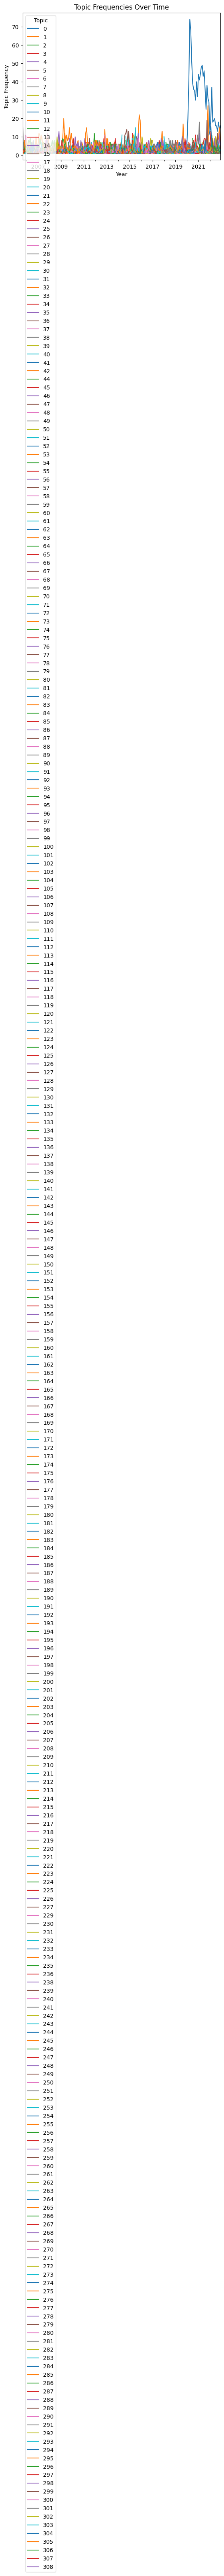

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by "Topic" and "Timestamp" and aggregate "Frequency"
grouped_df = df_1.groupby(['Topic', 'Timestamp'])['Frequency'].sum().reset_index()

# Pivot the DataFrame to get years on the x-axis and Topic Frequencies as columns
pivot_df = grouped_df.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Plot the data with a legend
pivot_df.plot(kind='line', legend=True)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Topic Frequency')
plt.title('Topic Frequencies Over Time')

# Show the plot
plt.show()

# The pivot_df DataFrame can be used for time series analysis

Nice, this worked the way I want to, this can be used for time series modelling.

In [120]:
grouped_df 

,Topic,Timestamp,Frequency
0,0,2005-09-01,1
1,0,2005-10-01,1
2,0,2005-11-01,2
3,0,2006-01-01,1
4,0,2006-02-01,3
...,...,...,...
17702,308,2018-01-01,1
17703,308,2018-09-01,1
17704,308,2019-05-01,2
17705,308,2021-04-01,1


In [121]:
pivot_df  # The values in the dataframe are the topic freqencies for each topic for each year

Topic,0,1,2,3,4,5,6,7,8,9,...,299,300,301,302,303,304,305,306,307,308
Timestamp,,,,,,,,,,,,,,,,,,,,,
2005-09-01,1.0,3.0,8.0,1.0,1.0,1.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2005-10-01,1.0,2.0,6.0,2.0,7.0,1.0,3.0,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0
2005-11-01,2.0,7.0,3.0,5.0,NaN,2.0,2.0,1.0,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-12-01,NaN,3.0,3.0,2.0,3.0,NaN,5.0,2.0,1.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-01,1.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,3.0,3.0,3.0,4.0,3.0,1.0,2.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-01,NaN,4.0,8.0,3.0,1.0,NaN,1.0,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-04-01,1.0,1.0,7.0,4.0,2.0,1.0,2.0,2.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,NaN,7.0,9.0,2.0,1.0,4.0,1.0,5.0,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


Without Covid (Outlier) and for the remaining Top 10 Topics:

In [21]:
new_df = df_0[(df_0['Topic'] >= 1) & (df_0['Topic'] <= 10)]

With monthly df_1:

In [22]:
new_df_2 = df_1[(df_1['Topic'] >= 1) & (df_1['Topic'] <= 10)]

In [25]:
new_df 

,Topic,Timestamp,Words,Frequency
19,1,2005,"climate, kyoto, emissions, change, conference",15
20,1,2006,"climate, emissions, change, carbon, warming",54
21,1,2007,"climate, emissions, change, carbon, warming",90
22,1,2008,"climate, emissions, change, energy, carbon",50
23,1,2009,"climate, copenhagen, emissions, energy, change",114
24,1,2010,"climate, emissions, change, ipcc, warming",64
25,1,2011,"climate, emissions, durban, change, energy",60
26,1,2012,"climate, kyoto, energy, emissions, change",52
27,1,2013,"climate, emissions, warming, uncertainties, change",44
28,1,2014,"climate, emissions, energy, change, greenhousegas",46


In [24]:
new_df_2

,Topic,Timestamp,Words,Frequency,Name
125,1,2005-09-01,"19282005, keeling, halve, 2050, charles",3,1_climate_emissions_change_warming
126,1,2005-10-01,"climbs, soaring, warnings, ministers, posed",2,1_climate_emissions_change_warming
127,1,2005-11-01,"climate, emissions, policy, petit, bamzai",7,1_climate_emissions_change_warming
128,1,2005-12-01,"conference, kyoto, montreal, twintrack, signing",3,1_climate_emissions_change_warming
129,1,2006-01-01,"unimpressed, clean, alternativeenergy, asiapacific, climate",5,1_climate_emissions_change_warming
...,...,...,...,...,...
1918,10,2022-08-01,"loved, dissonant, regarding, broken, one",2,10_time_its_home_remember
1919,10,2022-09-01,"garden, behind, reflection, keeping, moment",2,10_time_its_home_remember
1920,10,2022-10-01,"sisterly, invents, girl, still, place",4,10_time_its_home_remember
1921,10,2022-11-01,"struthers, watchmaker, orphans, vintage, testament",3,10_time_its_home_remember


Plotting the frequencies over time of the top then topics:

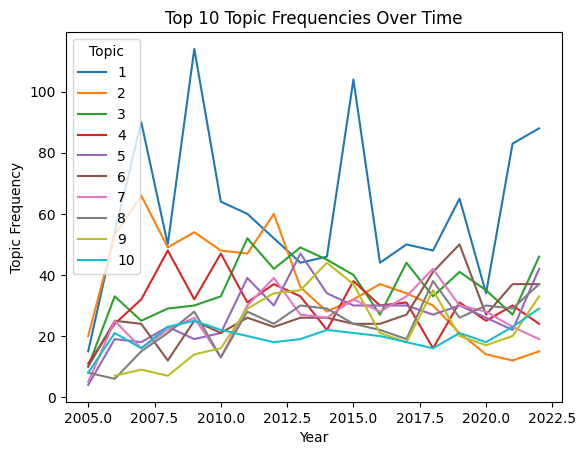

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by "Topic" and "Timestamp" and aggregate "Frequency"
grouped_df = new_df.groupby(['Topic', 'Timestamp'])['Frequency'].sum().reset_index()

# Pivot the DataFrame to get years on the x-axis and Topic Frequencies as columns
pivot_df = grouped_df.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Plot the data with a legend
pivot_df.plot(kind='line', legend=True)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Topic Frequency')
plt.title('Top 10 Topic Frequencies Over Time')

# Show the plot
plt.show()

# The pivot_df DataFrame can be used for time series analysis

With monthly timestamps:

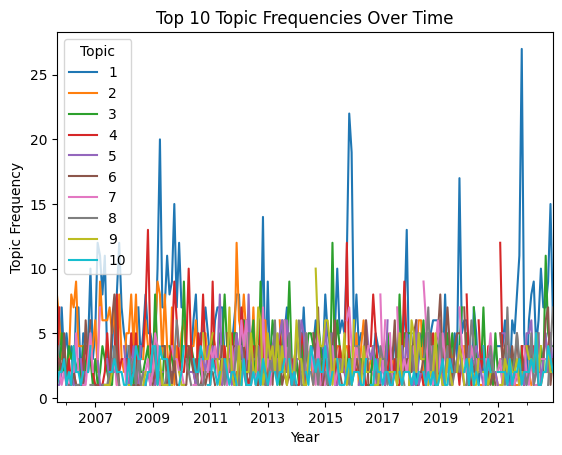

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by "Topic" and "Timestamp" and aggregate "Frequency"
grouped_df_2 = new_df_2.groupby(['Topic', 'Timestamp'])['Frequency'].sum().reset_index()

# Pivot the DataFrame to get years on the x-axis and Topic Frequencies as columns
pivot_df_2 = grouped_df_2.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Plot the data with a legend
pivot_df_2.plot(kind='line', legend=True)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Topic Frequency')
plt.title('Top 10 Topic Frequencies Over Time')

# Show the plot
plt.show()

# The pivot_df DataFrame can be used for time series analysis

# Timeseries modelling:

First step: Filling NaN values with zero:

In [122]:
pivot_df.fillna(0, inplace=True) 

In [123]:
pivot_df

Topic,0,1,2,3,4,5,6,7,8,9,...,299,300,301,302,303,304,305,306,307,308
Timestamp,,,,,,,,,,,,,,,,,,,,,
2005-09-01,1.0,3.0,8.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2005-10-01,1.0,2.0,6.0,2.0,7.0,1.0,3.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2005-11-01,2.0,7.0,3.0,5.0,0.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-12-01,0.0,3.0,3.0,2.0,3.0,0.0,5.0,2.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-01,1.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-02-01,3.0,3.0,3.0,4.0,3.0,1.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-01,0.0,4.0,8.0,3.0,1.0,0.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-04-01,1.0,1.0,7.0,4.0,2.0,1.0,2.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-05-01,0.0,7.0,9.0,2.0,1.0,4.0,1.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [124]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2005-09-01 to 2022-12-01
Columns: 305 entries, 0 to 308
dtypes: float64(305)
memory usage: 497.2 KB


Resetting the index:

In [125]:
pivot_df_2 = pivot_df.reset_index()

In [126]:
pivot_df_2

Topic,Timestamp,0,1,2,3,4,5,6,7,8,...,299,300,301,302,303,304,305,306,307,308
0,2005-09-01,1.0,3.0,8.0,1.0,1.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2005-10-01,1.0,2.0,6.0,2.0,7.0,1.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2005-11-01,2.0,7.0,3.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005-12-01,0.0,3.0,3.0,2.0,3.0,0.0,5.0,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2006-01-01,1.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2006-02-01,3.0,3.0,3.0,4.0,3.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2006-03-01,0.0,4.0,8.0,3.0,1.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2006-04-01,1.0,1.0,7.0,4.0,2.0,1.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2006-05-01,0.0,7.0,9.0,2.0,1.0,4.0,1.0,5.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,2006-06-01,1.0,7.0,4.0,3.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Somehow index has 'Topic' as header, trying to change that:

In [127]:
pivot_df_2.Topic = 'Index'

In [128]:
pivot_df_2

Topic,Timestamp,0,1,2,3,4,5,6,7,8,...,299,300,301,302,303,304,305,306,307,308
0,2005-09-01,1.0,3.0,8.0,1.0,1.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2005-10-01,1.0,2.0,6.0,2.0,7.0,1.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2005-11-01,2.0,7.0,3.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005-12-01,0.0,3.0,3.0,2.0,3.0,0.0,5.0,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2006-01-01,1.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2006-02-01,3.0,3.0,3.0,4.0,3.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2006-03-01,0.0,4.0,8.0,3.0,1.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2006-04-01,1.0,1.0,7.0,4.0,2.0,1.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2006-05-01,0.0,7.0,9.0,2.0,1.0,4.0,1.0,5.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,2006-06-01,1.0,7.0,4.0,3.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Unfortunately this did not work.

Resetting the index:

In [129]:
pivot_df_3 = pivot_df_2.reset_index()

In [138]:
pivot_df_3

Topic,Timestamp,0,1,2,3,4,5,6,7,8,...,299,300,301,302,303,304,305,306,307,308
0,2005-09-01,1.0,3.0,8.0,1.0,1.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2005-10-01,1.0,2.0,6.0,2.0,7.0,1.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2005-11-01,2.0,7.0,3.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005-12-01,0.0,3.0,3.0,2.0,3.0,0.0,5.0,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2006-01-01,1.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2006-02-01,3.0,3.0,3.0,4.0,3.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2006-03-01,0.0,4.0,8.0,3.0,1.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2006-04-01,1.0,1.0,7.0,4.0,2.0,1.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2006-05-01,0.0,7.0,9.0,2.0,1.0,4.0,1.0,5.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,2006-06-01,1.0,7.0,4.0,3.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
pivot_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Columns: 307 entries, index to 308
dtypes: datetime64[ns](1), float64(305), int64(1)
memory usage: 499.0 KB


Topic remains as the header of the index.

In [132]:
del pivot_df_3['index']

'Topic' could not be deleted, therefore 'index' was deleted.

Index has Topic as header, but otherwise this dataframe looks like I want it to.

In [110]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from xgboost import plot_importance


In [133]:
# Separating the training set and testing set
train_data=pivot_df_3[pivot_df_3['Timestamp'].dt.year<2018].reset_index(drop = True)
test_data=pivot_df_3[pivot_df_3['Timestamp'].dt.year>2017].reset_index(drop = True)

In [135]:
train_data.head()

Topic,Timestamp,0,1,2,3,4,5,6,7,8,...,299,300,301,302,303,304,305,306,307,308
0,2005-09-01,1.0,3.0,8.0,1.0,1.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2005-10-01,1.0,2.0,6.0,2.0,7.0,1.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2005-11-01,2.0,7.0,3.0,5.0,0.0,2.0,2.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005-12-01,0.0,3.0,3.0,2.0,3.0,0.0,5.0,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2006-01-01,1.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Topic should be Index, cannot change that, the topics are the columns 0 to 308.

In [81]:
# Define the target column (Topic you want to forecast)
target_topic = 1  # Change this to the Topic you want to forecast

# Prepare the training and testing data
X_train = train_data.drop(target_topic, axis=1)
y_train = train_data[target_topic]  # Shift by 1 to align with next year's frequency
X_test = test_data.drop(target_topic, axis=1)
y_test = test_data[target_topic]


Trying out forecast modelling with XGBoost:

Root Mean Squared Error (RMSE): 5.24403711526288


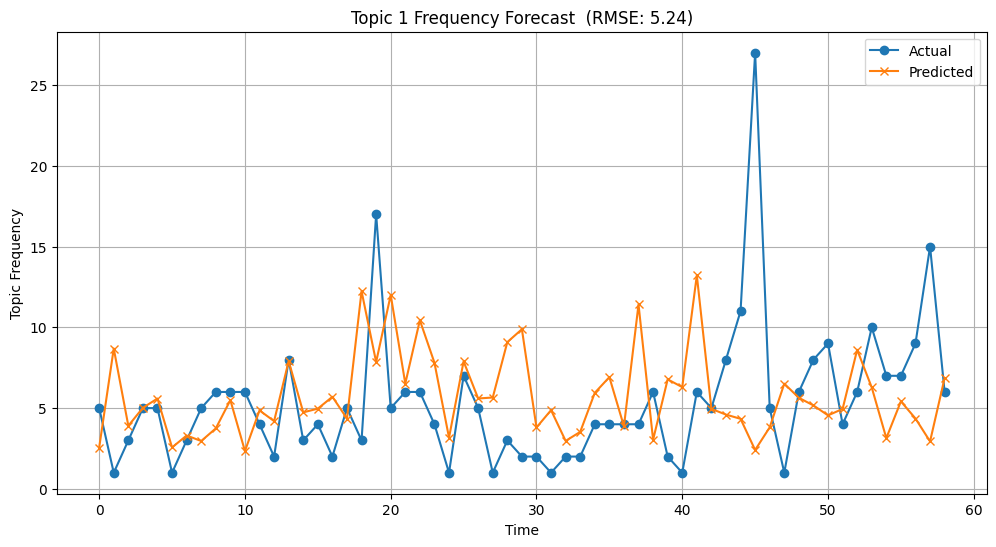

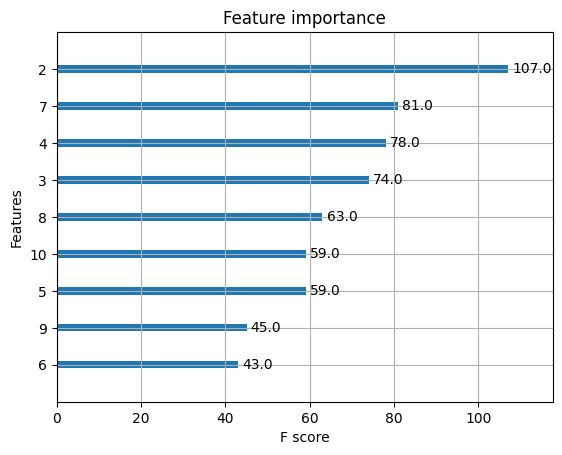

In [86]:

# Shift the target column to align with next year's frequency
y_train = train_data[target_topic].shift(-1).dropna()
y_test = test_data[target_topic].shift(-1).dropna()

# Exclude the 'Timestamp' column from the training and testing data
X_train = train_data.drop(columns=['Timestamp', target_topic]).iloc[:-1]
X_test = test_data.drop(columns=['Timestamp', target_topic]).iloc[:-1]

# Create an XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[:-1], y_test, label='Actual', marker='o')
plt.plot(test_data.index[:-1], y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Topic Frequency')
plt.title(f'Topic {target_topic} Frequency Forecast  (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)

# Feature importance plot (optional)
plot_importance(model)
plt.show()


In [140]:
y_pred_df.head(10)

,Timestamp,Predicted
0,2018-01-01,2.556837
1,2018-02-01,8.687447
2,2018-03-01,3.905199
3,2018-04-01,5.019799
4,2018-05-01,5.593947
5,2018-06-01,2.565577
6,2018-07-01,3.303503
7,2018-08-01,2.963125
8,2018-09-01,3.742630
9,2018-10-01,5.494097


In [142]:
train_data.head(10)

Topic,Timestamp,1,2,3,4,5,6,7,8,9,10
0,2005-09-01,3.0,8.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0
1,2005-10-01,2.0,6.0,2.0,7.0,1.0,3.0,2.0,4.0,0.0,2.0
2,2005-11-01,7.0,3.0,5.0,0.0,2.0,2.0,1.0,0.0,0.0,2.0
3,2005-12-01,3.0,3.0,2.0,3.0,0.0,5.0,2.0,1.0,0.0,3.0
4,2006-01-01,5.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
5,2006-02-01,3.0,3.0,4.0,3.0,1.0,2.0,1.0,1.0,0.0,2.0
6,2006-03-01,4.0,8.0,3.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0
7,2006-04-01,1.0,7.0,4.0,2.0,1.0,2.0,2.0,0.0,3.0,4.0
8,2006-05-01,7.0,9.0,2.0,1.0,4.0,1.0,5.0,1.0,0.0,2.0
9,2006-06-01,7.0,4.0,3.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0


In [139]:
test_data.head(10)

Topic,Timestamp,1,2,3,4,5,6,7,8,9,10
0,2018-01-01,2.0,3.0,5.0,1.0,1.0,2.0,3.0,4.0,6.0,1.0
1,2018-02-01,5.0,0.0,0.0,0.0,1.0,5.0,4.0,2.0,5.0,2.0
2,2018-03-01,1.0,3.0,2.0,1.0,6.0,6.0,2.0,0.0,2.0,1.0
3,2018-04-01,3.0,6.0,0.0,1.0,1.0,0.0,2.0,5.0,5.0,2.0
4,2018-05-01,5.0,6.0,4.0,2.0,2.0,2.0,0.0,3.0,3.0,0.0
5,2018-06-01,5.0,1.0,6.0,1.0,0.0,3.0,9.0,3.0,3.0,2.0
6,2018-07-01,1.0,1.0,2.0,0.0,1.0,5.0,6.0,4.0,0.0,1.0
7,2018-08-01,3.0,0.0,5.0,0.0,5.0,2.0,1.0,7.0,1.0,2.0
8,2018-09-01,5.0,3.0,3.0,2.0,0.0,5.0,4.0,2.0,2.0,1.0
9,2018-10-01,6.0,2.0,1.0,5.0,4.0,2.0,1.0,4.0,2.0,2.0


Solving this issue by creating a dataframe with 'Timestamp' and the predicted values after modelling,
this dataframe can then be merged with the original test data to get a dataframe with both those informations in a time dependent manner.
Then a plot can be created by combining three subplots for the train data, the predicted values and the actual values:


Root Mean Squared Error (RMSE): 5.24403711526288


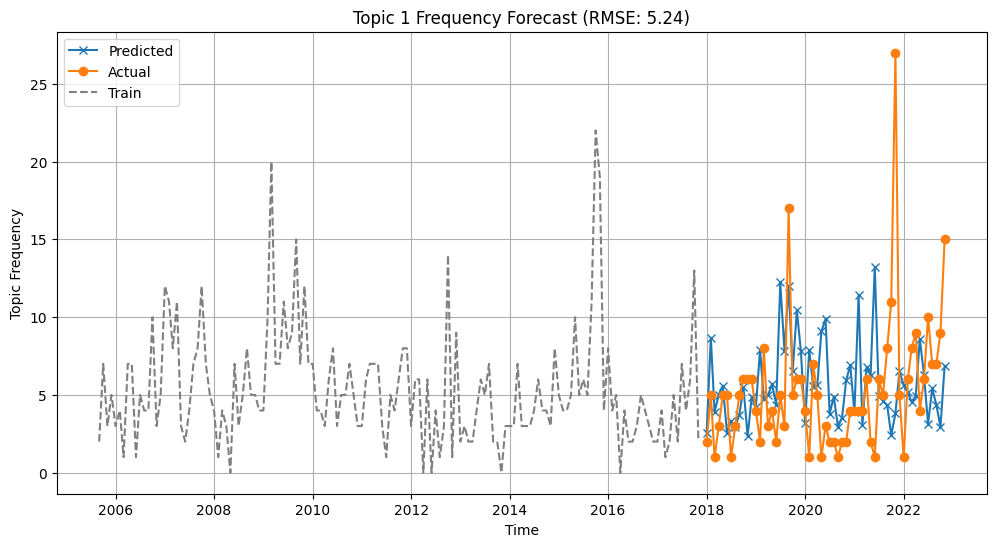

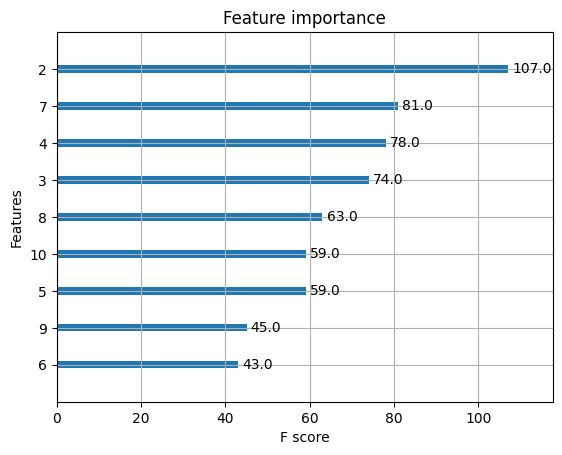

In [87]:
# Shift the target column to align with next year's frequency
y_train = train_data[target_topic].shift(-1).dropna()
y_test = test_data[target_topic].shift(-1).dropna()

# Exclude the 'Timestamp' column from the training and testing data
X_train = train_data.drop(columns=['Timestamp', target_topic]).iloc[:-1]
X_test = test_data.drop(columns=['Timestamp', target_topic]).iloc[:-1]

# Create an XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Create a DataFrame with Timestamp and the predicted values
y_pred_df = pd.DataFrame({'Timestamp': test_data['Timestamp'].iloc[:-1], 'Predicted': y_pred})

# Merge the predicted DataFrame with the original test_data DataFrame
merged_data = pd.merge(y_pred_df, test_data, on='Timestamp')

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the predicted vs. actual values along with y_train
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Timestamp'], merged_data['Predicted'], label='Predicted', marker='x')
plt.plot(merged_data['Timestamp'], merged_data[target_topic], label='Actual', marker='o')
plt.plot(train_data['Timestamp'].iloc[:-1], y_train, label='Train', linestyle='--', color='gray')
plt.xlabel('Time')
plt.ylabel('Topic Frequency')
plt.title(f'Topic {target_topic} Frequency Forecast (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)

# Feature importance plot (optional)
plot_importance(model)
plt.show()

To make a time series prediction for all topic frequencies, you can modify your code to iterate through each target topic and perform the prediction for each one. Here's the modified code:

In [117]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Define the list of target topics you want to forecast
target_topics = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# Create an empty dictionary to store RMSE values for each topic
rmse_values = {}

for target_topic in target_topics:
    # Split the data into training (up to 2017) and testing (from 2018) sets
    train_data=pivot_df_4[pivot_df_4['Timestamp'].dt.year<2018].reset_index(drop = True)
    test_data=pivot_df_4[pivot_df_4['Timestamp'].dt.year>2017].reset_index(drop = True)

    # Prepare the training and testing data
    X_train = train_data.drop(target_topic, axis=1)
    y_train = train_data[target_topic].shift(-1).dropna()  # Shift by 1 to align with next year's frequency
    X_test = test_data.drop(target_topic, axis=1)
    y_test = test_data[target_topic].shift(-1).dropna()

    # Create an XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Calculate the root mean squared error (RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_values[target_topic] = rmse

    # Plot the predicted vs. actual values
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index[:-1], y_test, label='Actual', marker='o')
    plt.plot(test_data.index[:-1], y_pred, label='Predicted', marker='x')
    plt.xlabel('Year')
    plt.ylabel('Topic Frequency')
    plt.title(f'Topic {target_topic} Frequency Forecast (RMSE: {rmse:.2f})')
    plt.legend()
    plt.grid(True)

    # Feature importance plot (optional)
    plot_importance(model)
    plt.show()

# Print RMSE values for all topics
for topic, rmse in rmse_values.items():
    print(f"Root Mean Squared Error (RMSE) for Topic {topic}: {rmse:.2f}")


KeyError: "['1'] not found in axis"